In [1]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.20/06


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.18.5 is currently installed but you installed root_numpy against numpy 1.16.4. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
#Bc -> tau nu signal
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu.root","events")
df_sig["EVT_thrutshemis_e_diff"] = df_sig["EVT_thrutshemis_e_max"] - df_sig["EVT_thrutshemis_e_min"]

In [3]:
#Bu -> tau nu signal
path = f"{loc.OUT}/ROOT"
df_Bu = read_root(f"{path}/Bu2TauNu.root","events")
df_Bu["EVT_thrutshemis_e_diff"] = df_Bu["EVT_thrutshemis_e_max"] - df_Bu["EVT_thrutshemis_e_min"]
df_Bu = df_Bu.sample(n=200000)

In [4]:
#Z -> qq inclusive
df_bkg = {}
for q in ["uds","cc","bb"]:
    df_bkg[q] = read_root(f"{path}/inclusive_Z{q}.root","events")
    df_bkg[q]["EVT_thrutshemis_e_diff"] = df_bkg[q]["EVT_thrutshemis_e_max"] - df_bkg[q]["EVT_thrutshemis_e_min"]
    df_bkg[q] = df_bkg[q].sample(n=200000)

In [5]:
#Plot x-axis title, axis min and max, and number of bins
var_config = {"EVT_thrutshemis_e_diff": ["Hemisphere energy difference [GeV]",0,50,40,"$E_{diff}$"],
              "EVT_thrutshemis_e_min": ["Hemisphere energy (min) [GeV]",0,50,40,"$E^{min}$"],
              "EVT_thrutshemis_e_max": ["Hemisphere energy (max) [GeV]",20,60,40,"$E^{max}$"],
              "echarged_min": ["Hemisphere charged energy (min) [GeV]",0,50,40,"$E_c^{min}$"],
              "echarged_max": ["Hemisphere charged energy (max) [GeV]",0,50,40,"$E_c^{max}$"],
              "eneutral_min": ["Hemisphere neutral energy (min) [GeV]",0,40,40,"$E_n^{min}$"],
              "eneutral_max": ["Hemisphere neutral energy (max) [GeV]",0,50,40,"$E_n^{max}$"],
              "ncharged_min": ["Hemisphere charged multiplicity (min)",0,22,22,"$M_c^{min}$"],
              "ncharged_max": ["Hemisphere charged multiplicity (max)",0,27,27,"$M_c^{max}$"],
              "nneutral_min": ["Hemisphere neutral multiplicity (min)",0,20,20,"$M_n^{min}$"],
              "nneutral_max": ["Hemisphere neutral multiplicity (max)",0,22,22,"$M_n^{max}$"]
             }

#Mode configs (quark names and colors to plot)
mode_config = {"sig": ["$B_c^+ \\to \\tau^+ \\nu_\\tau$","#d7191c"],
               "Bu": ["$B^+ \\to \\tau^+ \\nu_\\tau$","#313695"],
               "uds": ["q\\bar{q}","#fdae61"],
               "cc": ["c\\bar{c}","#abd9e9"],
               "bb": ["b\\bar{b}","#2c7bb6"]
              }

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


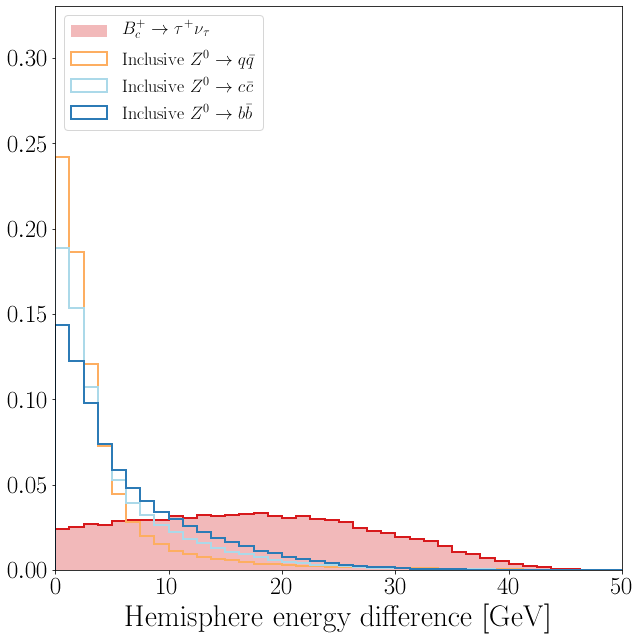

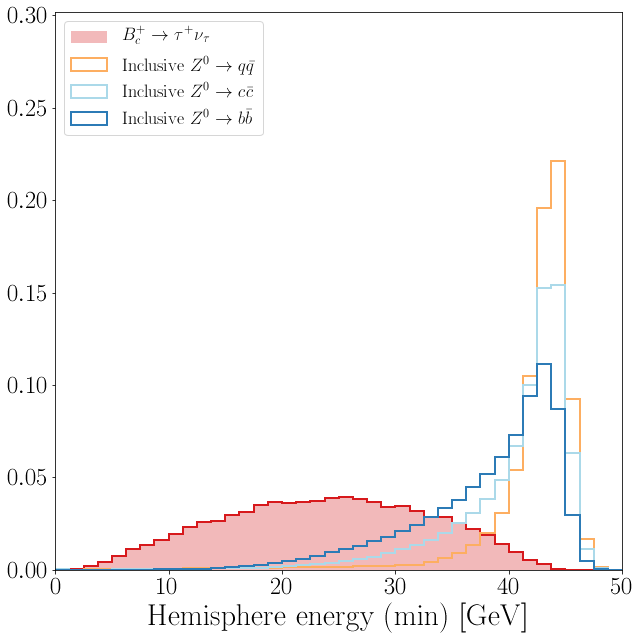

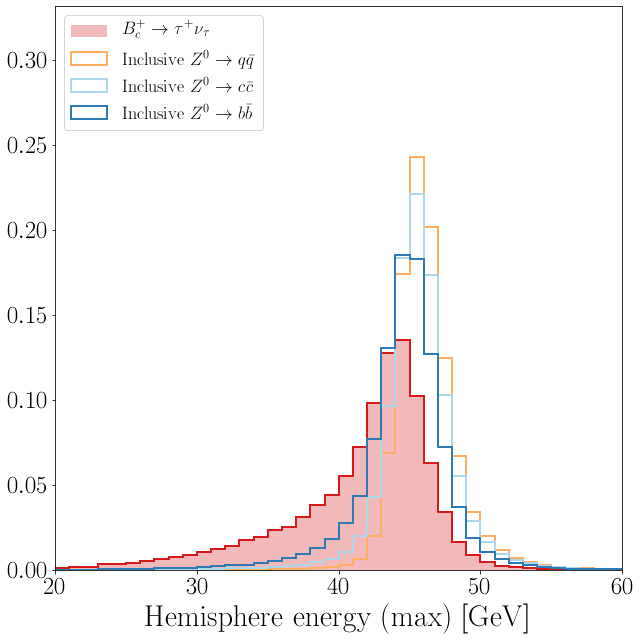

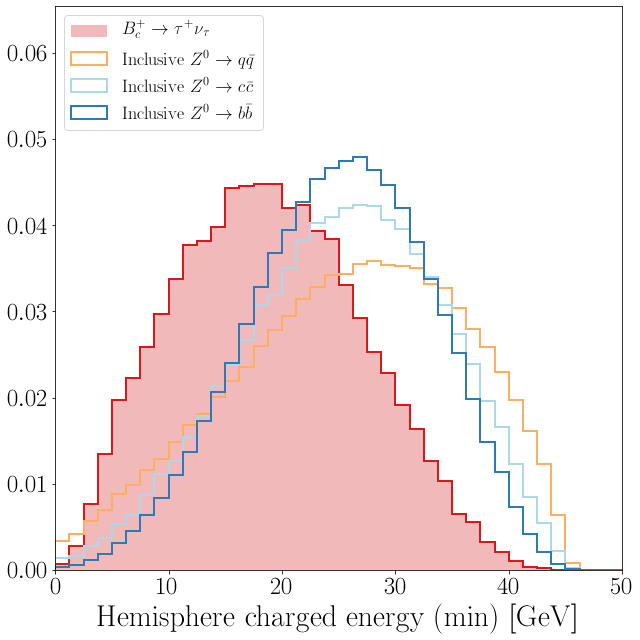

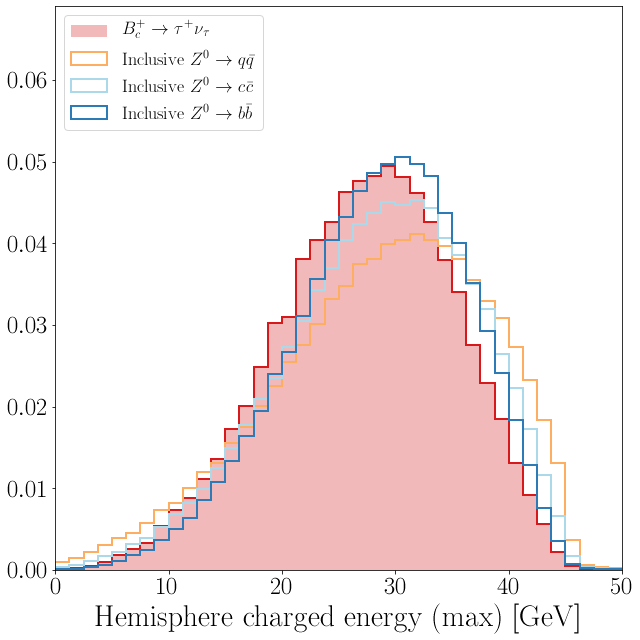

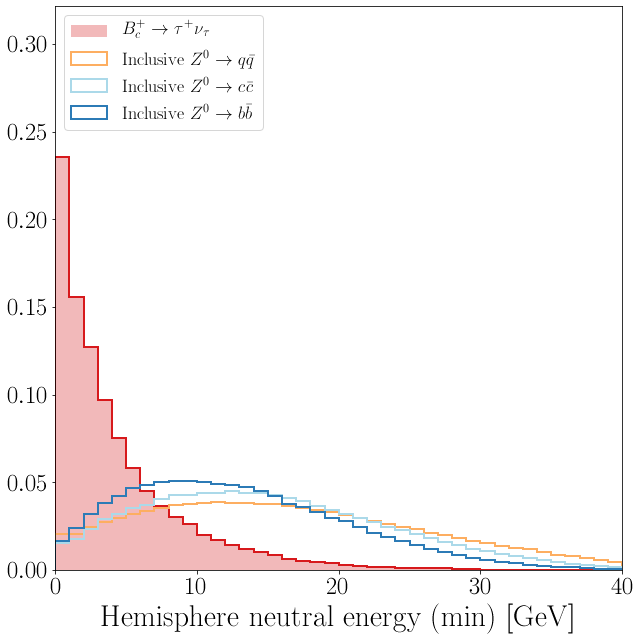

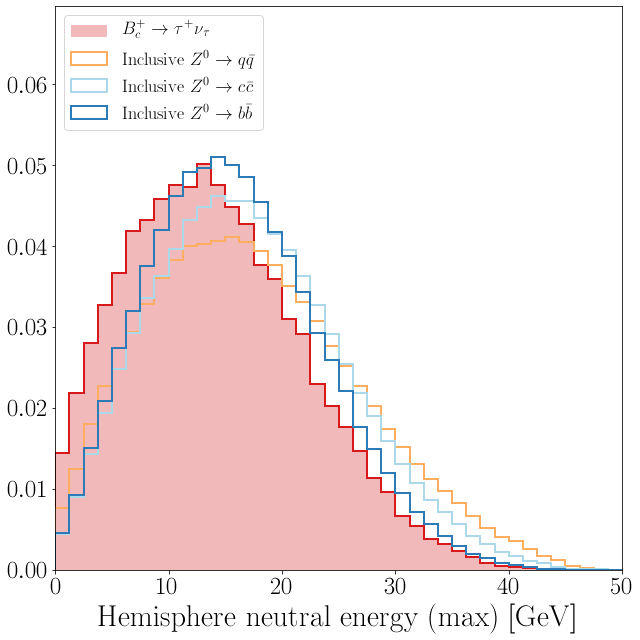

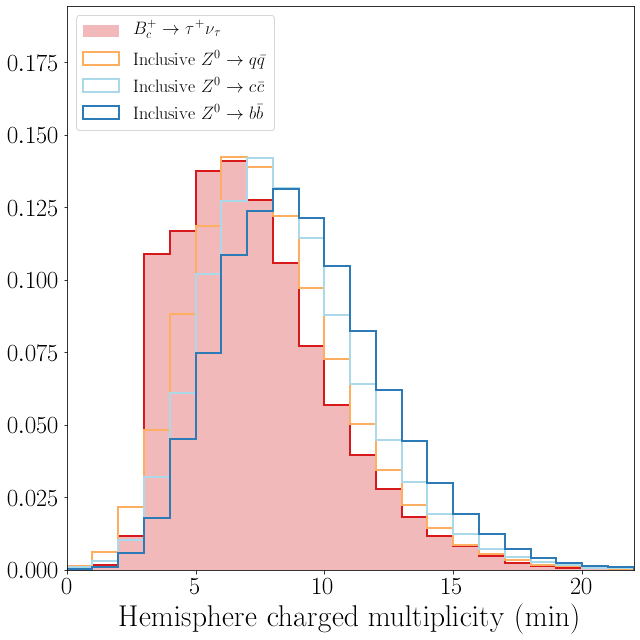

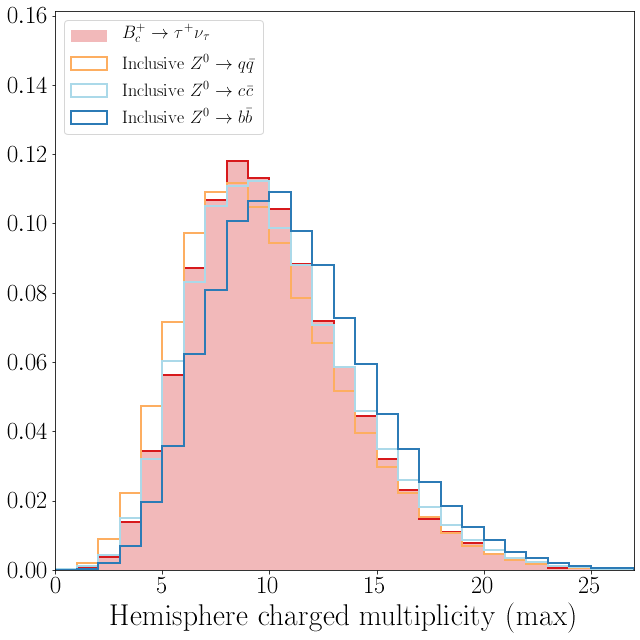

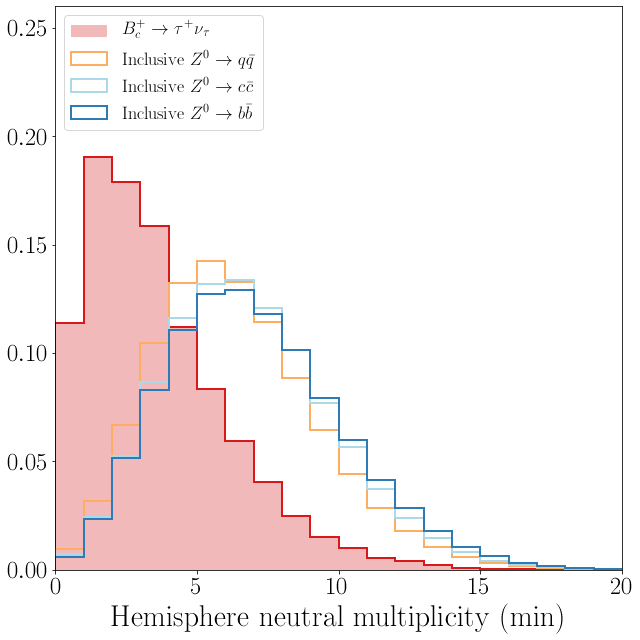

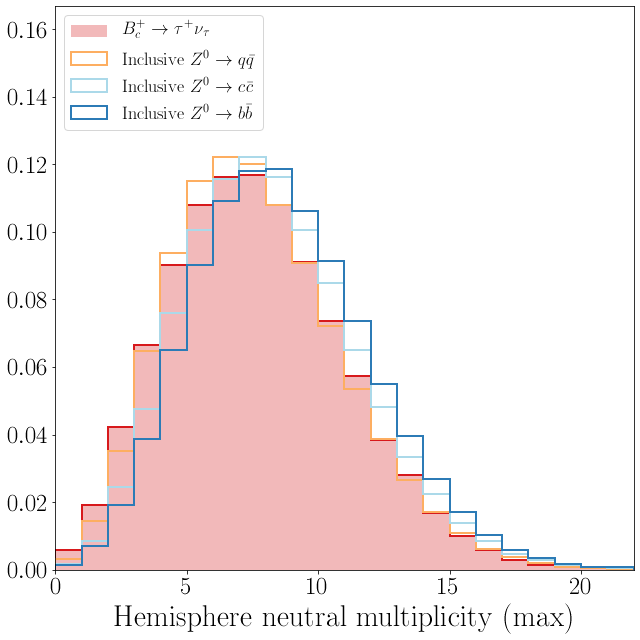

In [6]:
for v in var_config:
    fig, ax = plt.subplots(figsize=(9,9))
    plt.hist(df_sig[v],bins=var_config[v][3],color=mode_config["sig"][1],range=(var_config[v][1],var_config[v][2]),histtype='step',density=True,linewidth=2,label="")
    plt.hist(df_sig[v],bins=var_config[v][3],color=mode_config["sig"][1],range=(var_config[v][1],var_config[v][2]),histtype='stepfilled',density=True,alpha=0.3,label=mode_config["sig"][0])
    #plt.hist(df_Bu[v],bins=var_config[v][3],color=mode_config["Bu"][1],range=(var_config[v][1],var_config[v][2]),histtype='step',density=True,linewidth=2,label=mode_config["Bu"][0])
    for q in ["uds","cc","bb"]:
        plt.hist(df_bkg[q][v],bins=var_config[v][3],color=mode_config[q][1],range=(var_config[v][1],var_config[v][2]),histtype='step',density=True,linewidth=2,label="Inclusive $Z^0 \\to %s$" % mode_config[q][0])
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.xlim(var_config[v][1],var_config[v][2])
    plt.xlabel(var_config[v][0],fontsize=30)
    ymin,ymax = plt.ylim()
    plt.ylim(0,1.3*ymax)
    plt.legend(fontsize=18, loc="upper left")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zqq_{v}.pdf")

In [7]:
#Make correlation matrix for the variables
corr_vars = []
corr_var_names = []
for v in var_config:
    if(v!="EVT_thrutshemis_e_diff"):
        corr_vars.append(v)
        corr_var_names.append(var_config[v][4])

df_sig_corr = df_sig[corr_vars]
df_bkg_corr = {}
for q in ["uds","cc","bb"]:
    df_bkg_corr[q] = df_bkg[q][corr_vars]

In [8]:
#Signal correlation matrix
import seaborn as sns
sns.set(font_scale=2)
corr = df_sig_corr.corr().round(decimals=2)
corr = corr.where(abs(corr) > 0.01)
corr = corr.replace(np.nan, 0)
mask = np.triu(np.ones_like(corr, dtype=bool))

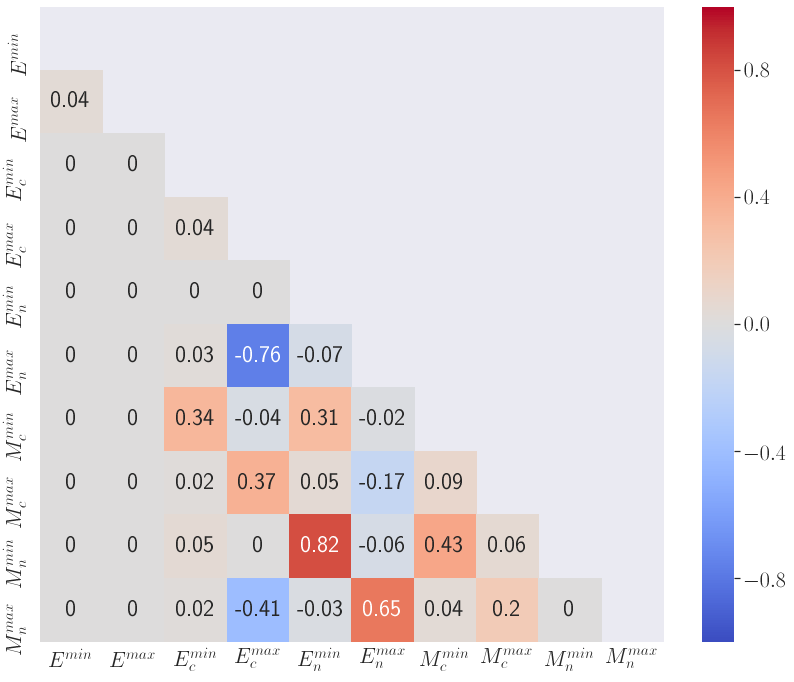

In [9]:
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, 
            xticklabels=corr_var_names,
            yticklabels=corr_var_names,
            vmin=-1,
            vmax=1,
            cmap="coolwarm",
            mask=mask,
            annot=True)
plt.tight_layout()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_var_corrs.pdf")

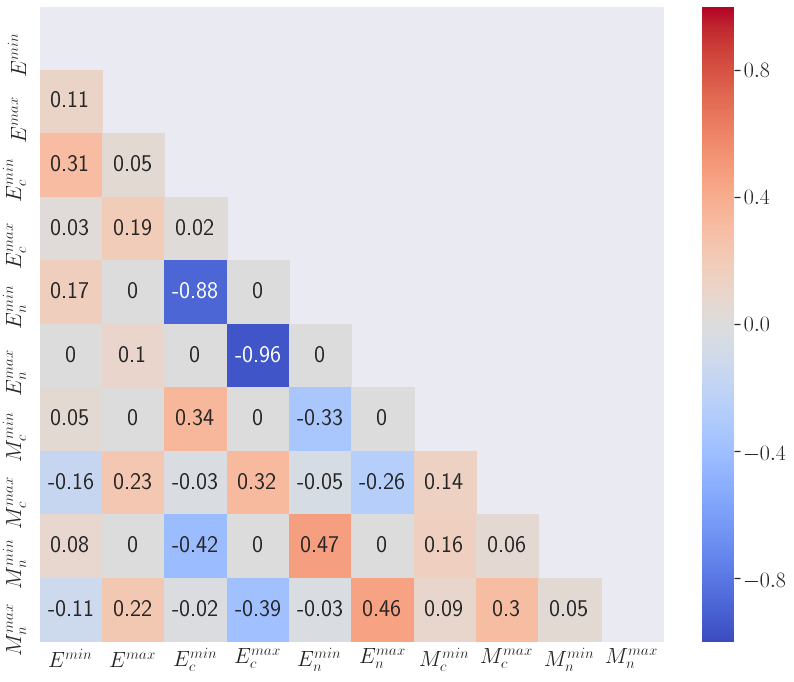

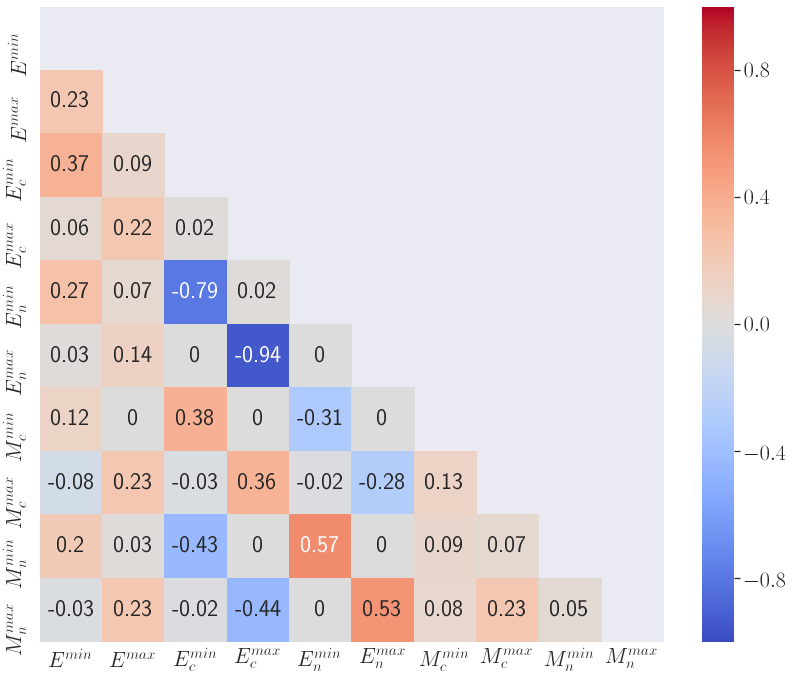

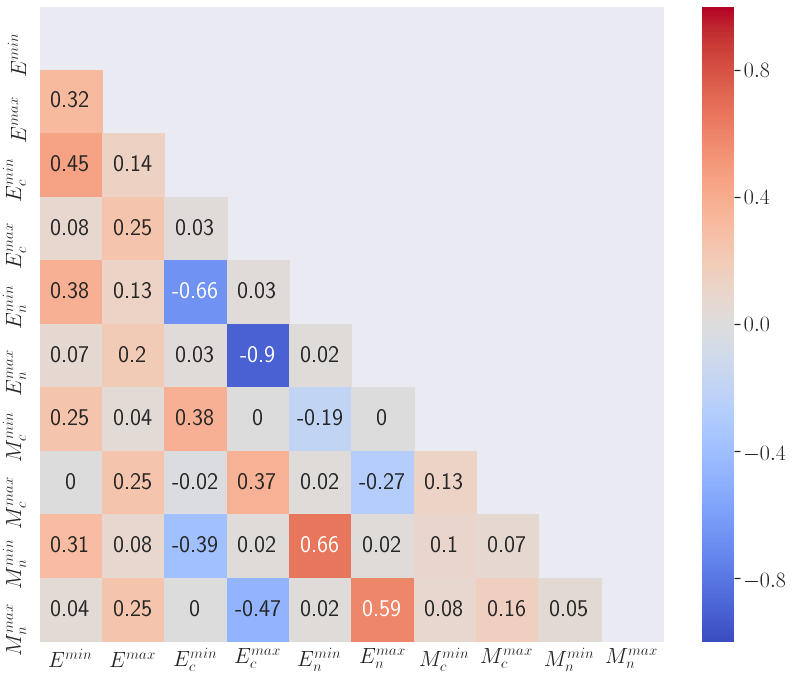

In [10]:
#Background correlation matrix
import seaborn as sns
sns.set(font_scale=2)
for q in ["uds","cc","bb"]:
    corr = df_bkg_corr[q].corr().round(decimals=2)
    corr = corr.where(abs(corr) > 0.01)
    corr = corr.replace(np.nan, 0)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig,ax = plt.subplots(figsize=(12,10))
    sns.heatmap(corr, 
                xticklabels=corr_var_names,
                yticklabels=corr_var_names,
                vmin=-1,
                vmax=1,
                cmap="coolwarm",
                mask=mask,
                annot=True)
    plt.tight_layout()
    fig.savefig(f"{loc.PLOTS}/inclusive_Z{q}_var_corrs.pdf")